### Diff-in-diff type study

$$y_{st} = \alpha + \beta_1\text{market prep}_{st} + \beta_2 \text{market creation}_{st} + \beta_3\text{market prep}_{st}\times\text{market creation}_{st} + X_{st} + \gamma_s + \mu_t + \varepsilon_{st} $$

where I define market preparation and market creation policies as below

In [159]:
**********************************************
****
**** OPENING DATA FOR Rachel Anderson
****
**********************************************
set more off
clear all
macro drop _all
clear matrix
drop _all 
cap log close
estimates clear

import delimited "/Users/rachelanderson/Dropbox (Princeton)/Research_V2/descriptive_solar/code/analysis/stata-policy-analysis/event_study/event-study-sample.csv"

**********************************************
****
**** Encode group identifiers
****
**********************************************

egen state_code = group(state)
egen region_code = group(region)

**********************************************
****
**** Outcomes
****
**********************************************


// Create log outcome variables
gen log_n_plants = log(n_plants+1)
gen log_ac_cap = log(ac_cap_added + 1)

gen log_n_plants_qf = log(n_plants_qf + 1)
gen log_ac_cap_qf = log(ac_cap_added_qf + 1)

gen log_cum_ac_cap = log(cum_ac_cap_added + 1)
gen log_cum_n_plants = log(cum_n_plants + 1)

gen cum_avg_cap = cum_ac_cap_added/cum_n_plants
replace cum_avg_cap = 0 if cum_avg_cap == .
replace avg_cap_ac = 0 if avg_cap_ac == .

gen log_cum_avg_plant = log(cum_avg_cap + 1)
label variable log_cum_avg_plant "Log Avg. Size"

label variable log_cum_ac_cap "Log Total Capacity"
label variable log_ac_cap "Log Capacity Additions"

label variable log_n_plants "Log # Plants Added"
label variable log_cum_n_plants "Log Total # Plants"

label variable cum_avg_cap "Avg. plant size"
label variable avg_cap_ac "Avg. new plant size"

gen log_avg_cap = log(avg_cap_ac + 1)
label variable log_avg_cap "Log avg. size"

// create capacity per cap
gen dc_per_cap = dc_cap_added/pop_2010
gen log_dc_per_cap = log(dc_per_cap +1)
label variable dc_per_cap "Megawatts per capita"
label variable log_dc_per_cap "Log MW per capita"

**********************************************
****
**** Label policy variables
****
**********************************************

label variable first_plant_yr "First installation"
label variable first_ipp_plant_yr "First IPP installation"

label variable first_carveout_year "First active carve-out"
label variable first_rps_year "First active RPS"

label variable itc_introduced "ITC introduced"
label variable itc_expired "ITC expired"

label variable ptc_introduced "PTC introduced"
label variable ptc_expired "PTC expired"









(57 vars, 750 obs)









(398 missing values generated)

(398 real changes made)

(0 real changes made)
























In [160]:
gen active_itc = 0
replace active_itc = 1 if year >= itc_start_yr & year <= itc_end_yr  
gen active_ptc = 0
replace active_ptc = 1 if year >= ptc_start_yr & year <= ptc_end_yr  

gen active_incentive = 0
replace active_incentive = 1 if active_itc == 1 | active_ptc == 1



(49 real changes made)


(75 real changes made)


(124 real changes made)


In [163]:
gen any_qf = 0
replace any_qf = 1 if cum_ac_cap_added_qf > 0 


gen qf_stack = any_qf*active_incentive



(277 real changes made)


In [167]:
xtset state_code year
xtreg log_ac_cap_qf any_qf , fe vce(cluster state_code)


       panel variable:  state_code (strongly balanced)
        time variable:  year, 2005 to 2019
                delta:  1 unit


Fixed-effects (within) regression               Number of obs     =        750
Group variable: state_code                      Number of groups  =         50

R-sq:                                           Obs per group:
     within  = 0.3580                                         min =         15
     between = 0.5676                                         avg =       15.0
     overall = 0.4131                                         max =         15

                                                F(1,49)           =     153.10
corr(u_i, Xb)  = 0.0639                         Prob > F          =     0.0000

                            (Std. Err. adjusted for 50 clusters in state_code)
------------------------------------------------------------------------------
             |               Robust
log_ac_cap~f |      Coef.   Std. Err.      t    P>|t|  

In [152]:
xtset state_code year
xtreg log_ac_cap any_plant active_solar_rps double_stack triple_stack, fe vce(cluster state_code)


       panel variable:  state_code (strongly balanced)
        time variable:  year, 2005 to 2019
                delta:  1 unit


Fixed-effects (within) regression               Number of obs     =        750
Group variable: state_code                      Number of groups  =         50

R-sq:                                           Obs per group:
     within  = 0.3359                                         min =         15
     between = 0.5379                                         avg =       15.0
     overall = 0.4030                                         max =         15

                                                F(4,49)           =      30.57
corr(u_i, Xb)  = 0.0342                         Prob > F          =     0.0000

                             (Std. Err. adjusted for 50 clusters in state_code)
-------------------------------------------------------------------------------
              |               Robust
   log_ac_cap |      Coef.   Std. Err.      t    P>|

In [157]:
tab any_plant double_stack
tab active_solar_rps double_stack
tab triple_stack



           |     double_stack
 any_plant |         0          1 |     Total
-----------+----------------------+----------
         0 |       426          0 |       426 
         1 |       200        124 |       324 
-----------+----------------------+----------
     Total |       626        124 |       750 


active_sol |     double_stack
    ar_rps |         0          1 |     Total
-----------+----------------------+----------
         0 |       604          0 |       604 
         1 |        22        124 |       146 
-----------+----------------------+----------
     Total |       626        124 |       750 


triple_stac |
          k |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        724       96.53       96.53
          1 |         26        3.47      100.00
------------+-----------------------------------
      Total |        750      100.00


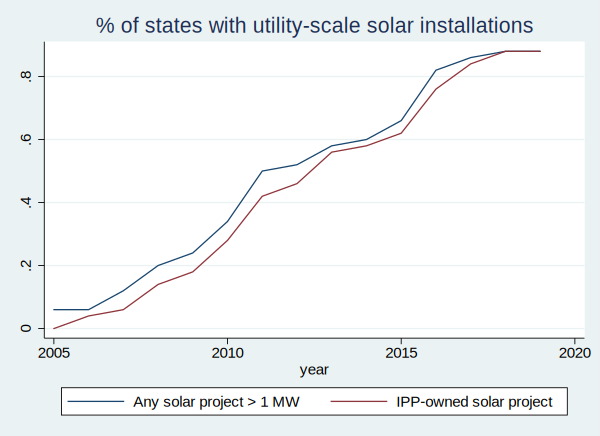

In [11]:
capture restore
capture preserve

collapse (sum) first_plant first_plant_pre_sample first_ipp_plant, by(year)
gen plants = sum(first_plant + first_plant_pre_sample)/50
gen ipp_plants = sum(first_ipp_plant)/50
label variable plants "Any solar project > 1 MW"
label variable ipp_plants "IPP-owned solar project"

twoway line plants year || line ipp_plants year, title("% of states with utility-scale solar installations")

restore





(555 observations deleted)


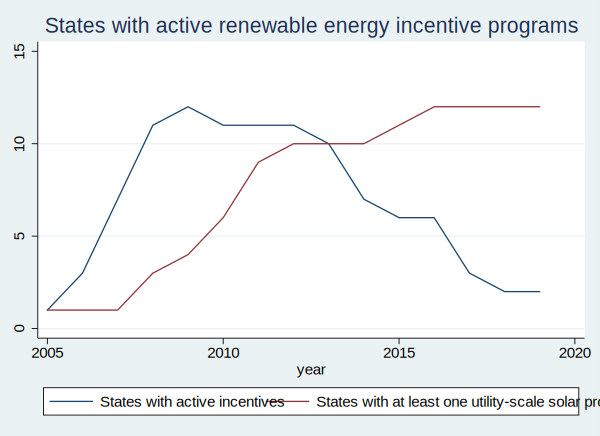

In [117]:
capture restore
capture preserve


bysort state: egen any_tc = max(itc_introduced + ptc_introduced)
drop if any_tc == 0 

global policy_list "first_plant first_plant_pre_sample first_ipp_plant ptc_introduced ptc_expired itc_introduced itc_expired"

collapse (sum) $policy_list, by(year)
gen cum_tc = sum(itc_introduced+ptc_introduced - ptc_expired -itc_expired)
gen plants = sum(first_plant + first_plant_pre_sample)
label variable cum_tc "States with active incentives"
label variable plants "States with at least one utility-scale solar project"

twoway line cum_tc year || line plants year, title("States with active renewable energy incentive programs") 

restore

In [118]:
gen active_itc = 0
replace active_itc = 1 if year >= itc_start_yr & year <= itc_end_yr  
gen active_ptc = 0
replace active_ptc = 1 if year >= ptc_start_yr & year <= ptc_end_yr  


variable active_itc already defined


r(110);
r(110);


In [115]:
capture restore
capture preserve

bysort state: egen active_tc = max(active_itc + active_ptc)
collapse (sum) active_tc first_plant first_plant_pre_sample, by(year)
// bysort active_tc (year): gen plants = sum(first_plant+first_plant_pre_sample)

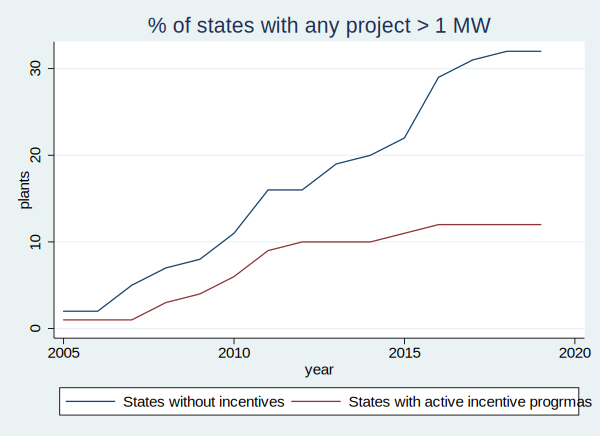

In [112]:
twoway line plants year if active_tc == 0 || line plants year if active_tc == 1, title("% of states with any project > 1 MW") legend(label(1 "States without incentives") label(2 "States with active incentive progrmas"))

In [105]:
capture restore
capture preserve

bysort state: egen any_tc = max(itc_introduced + ptc_introduced)
collapse (sum) first_plant first_plant_pre_sample, by(year any_tc)
bysort any_tc (year): gen plants = sum(first_plant+first_plant_pre_sample)

In [106]:
gen p_true = plants/15 if any_tc == 1
replace p_true = plants/35 if any_tc == 0 


(15 missing values generated)

(15 real changes made)


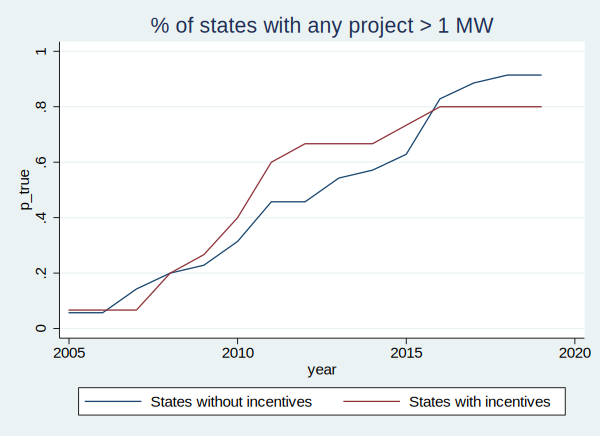

In [99]:
twoway line p_true year if any_tc == 0 || line p_true year if any_tc == 1, title("% of states with any project > 1 MW") legend(label(1 "States without incentives") label(2 "States with incentives"))